In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.utils import resample,shuffle
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler

In [ ]:
!unzip /content/tweet_data.zip


Archive:  /content/tweet_data.zip
  inflating: Twitter_Data.csv        


In [ ]:
df=pd.read_csv('/content/Twitter_Data.csv')#,encoding='latin-1')

In [ ]:
df.head(9).iloc[:,0:2]

,clean_text,category
0,when modi promised minimum government maximum ...,-1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp to...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1
5,kiya tho refresh maarkefir comment karo,0
6,surat women perform yagna seeks divine grace f...,0
7,this comes from cabinet which has scholars lik...,0
8,with upcoming election india saga going import...,1


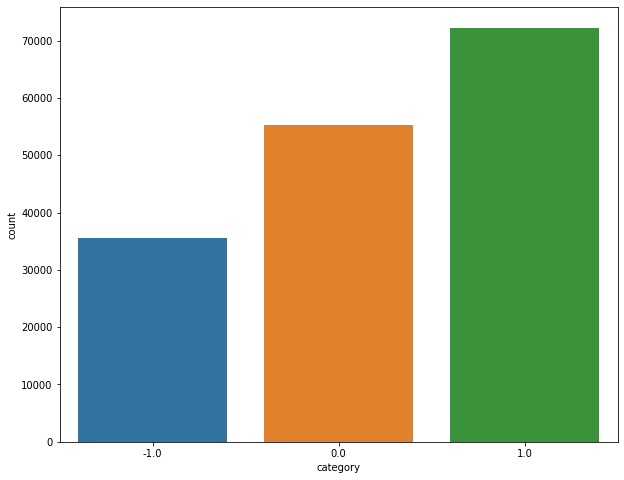

In [ ]:
# count of class label
plt.figure(figsize=(10,8))
sns.countplot(x='category',data=df)
plt.savefig('classes.png')
plt.show()

In [ ]:
# checking for duplicate tweets 
df.category.value_counts()
#there are few entries which has same tweet id, lets check those datapoints

 1.0    72250
 0.0    55213
-1.0    35510
Name: category, dtype: int64

In [ ]:
#checking for missing data
def missing(data):
    """ this functions checks for missing values"""
    total = data.isnull().sum()
    total=pd.DataFrame(total)
 
    return np.transpose(total)

missing(df)

,clean_text,category
0,4,7


In [ ]:
# removing NaN valued from data

df=df.fillna('NA')
df=df.loc[df.clean_text!='NA']
df=df.loc[df.category!='NA']

In [ ]:
missing(df)

,clean_text,category
0,0,0


In [ ]:
# we need to clean this text data and remove profile mentions, hashtags , urls, emoji signs etc
#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
def preprocess(txt):
    '''This function pre processes given text data'''
    txt=txt.replace('&amp;','and')
    txt=re.sub(r'http\S+', '', txt)
    txt=decontracted(txt)
    txt=" ".join(filter(lambda x:x[0]!='@', txt.split()))
    txt=" ".join(filter(lambda x:x[0]!='#', txt.split()))
    txt=" ".join(filter(lambda x:x[-4:]!='.com', txt.split()))
    txt=re.sub('[^A-Za-z ]+','', txt)

    return txt.lower().strip()

In [ ]:
# adding clean_text feature which has pre processed tweets for easy access 
df['clean_text']=df['clean_text'].apply(preprocess)

In [ ]:
df

,clean_text,category
0,when modi promised minimum government maximum ...,-1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp to...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1
...,...,...
162975,why these crores paid neerav modi not recover...,-1
162976,dear rss terrorist payal gawar what about modi...,-1
162977,did you cover her interaction forum where she ...,0
162978,there big project came into india modi dream p...,0


In [ ]:
# lets check for length of give tweet text, adding it as feature
def len_(txt):
    txt=txt.split()
    return len(txt)
df['len']=df['clean_text'].apply(len_)

In [ ]:
# max lenght is 40 words , min length is 1 and average is 12
max(df.len.values),min(df.len.values),np.mean(df.len.values)

(52, 0, 19.85284931490038)

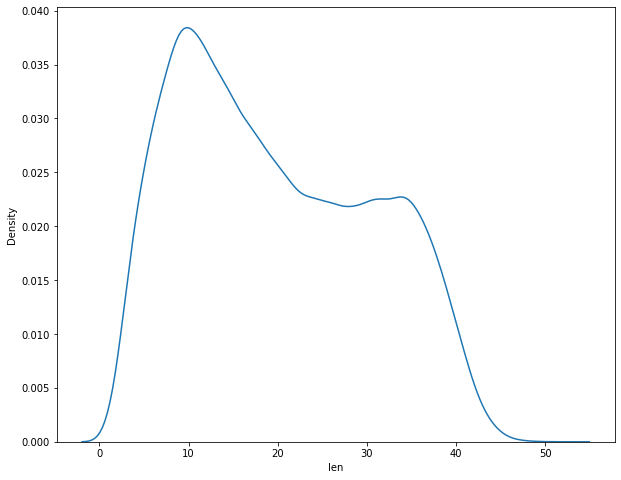

In [ ]:
plt.figure(figsize=(10,8))
sns.kdeplot(df['len'])
plt.savefig('pdf.png')
plt.show()

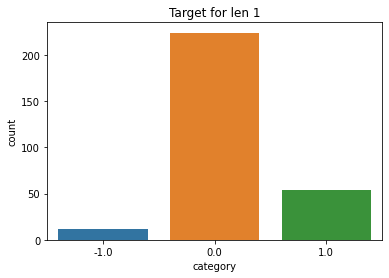

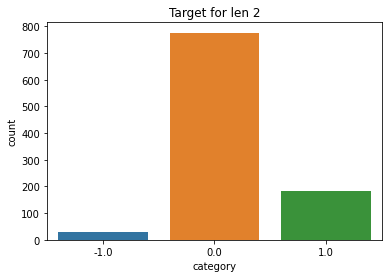

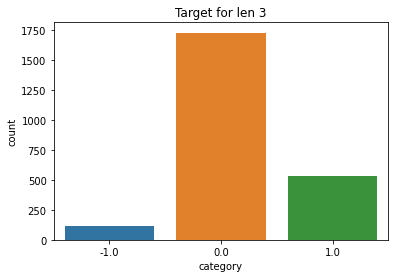

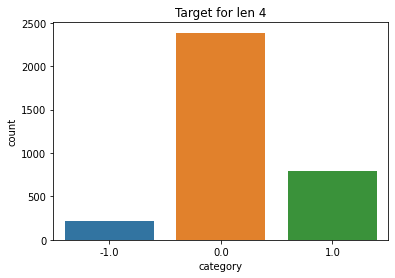

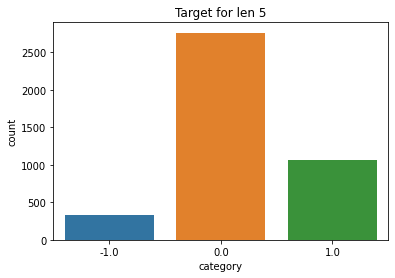

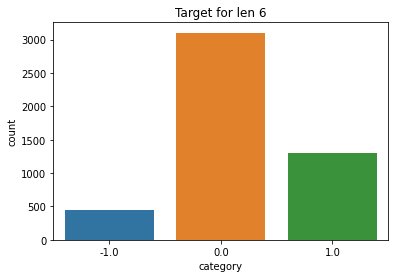

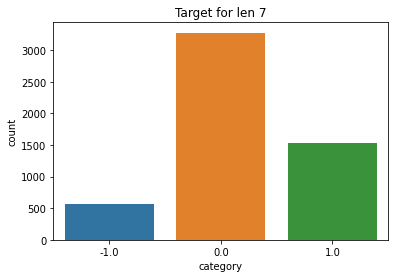

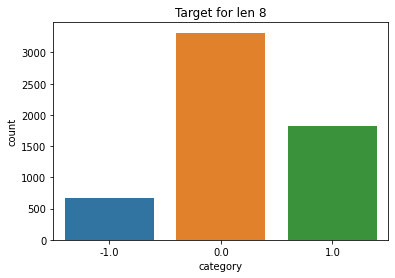

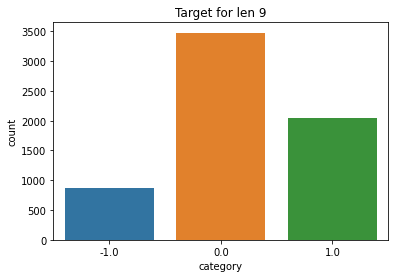

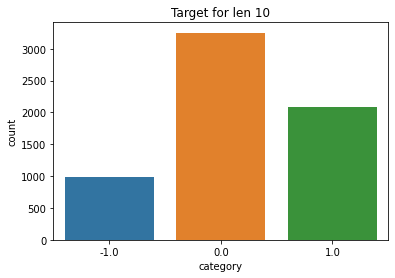

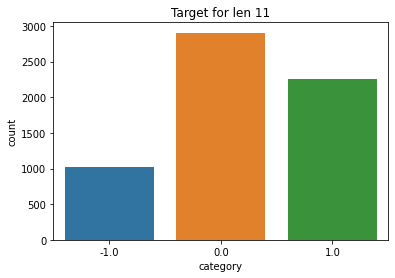

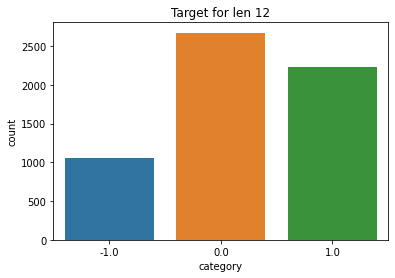

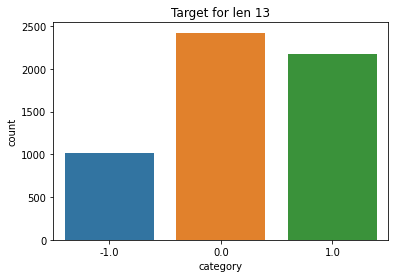

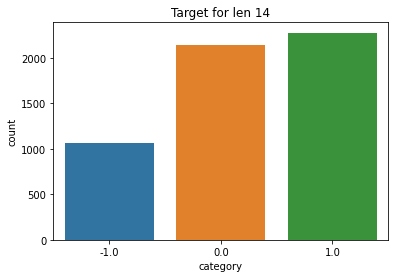

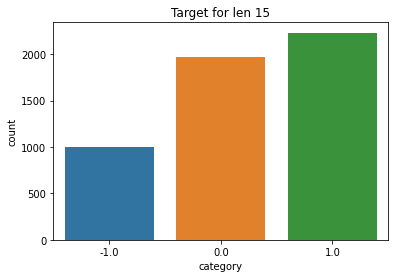

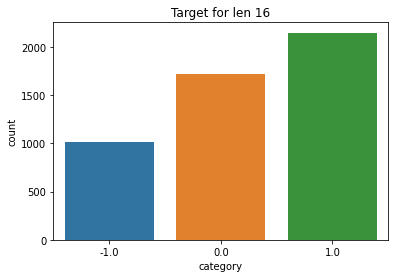

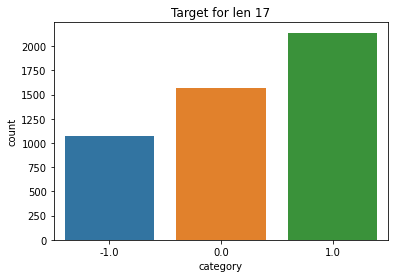

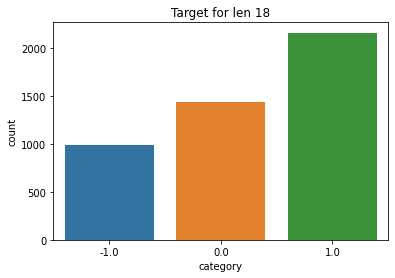

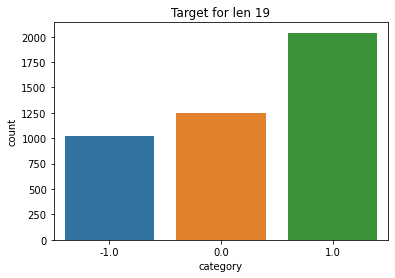

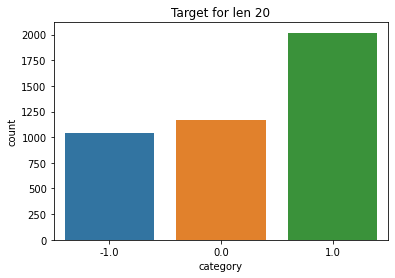

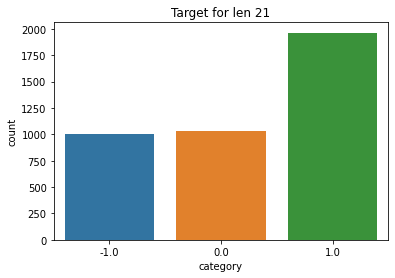

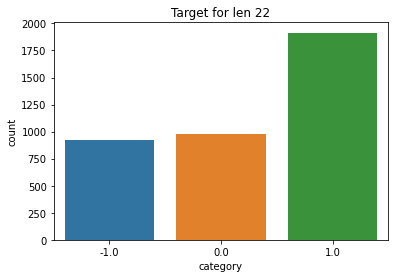

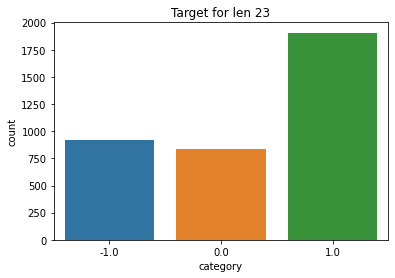

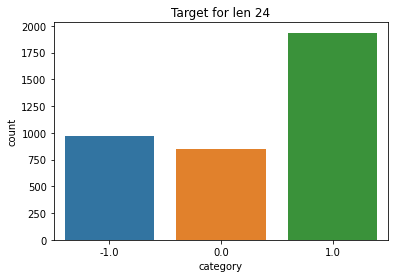

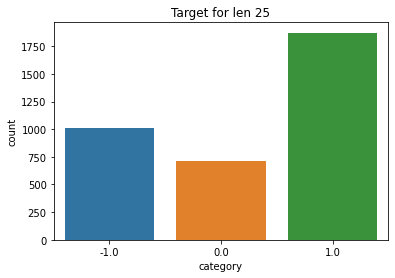

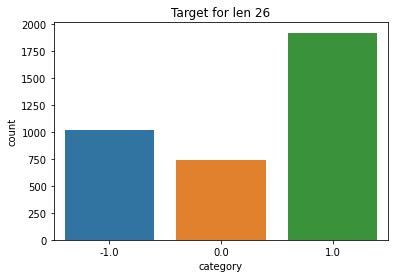

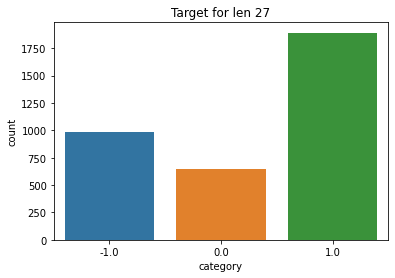

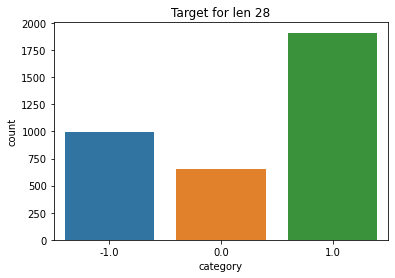

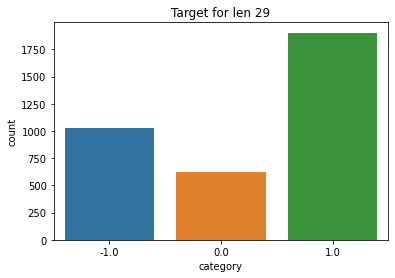

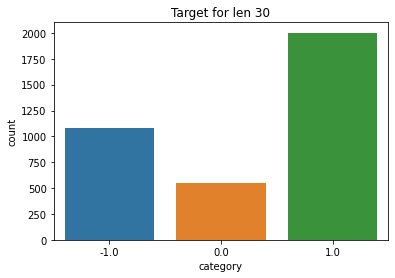

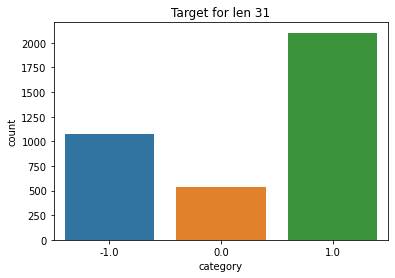

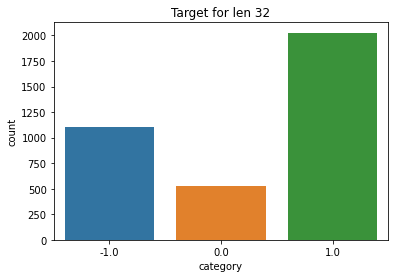

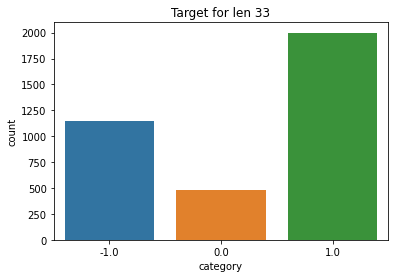

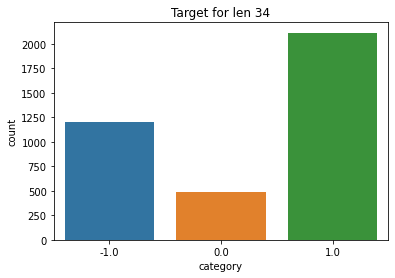

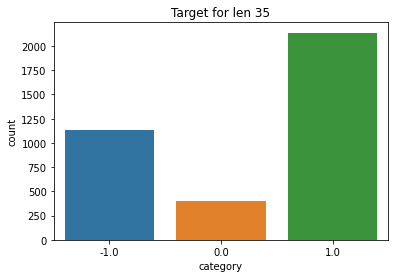

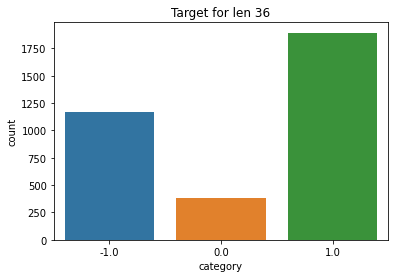

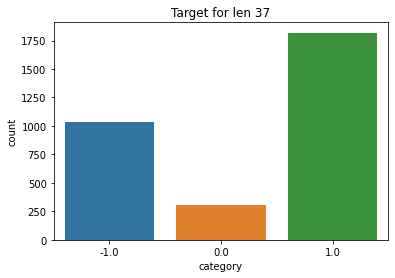

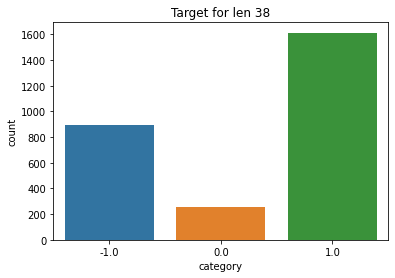

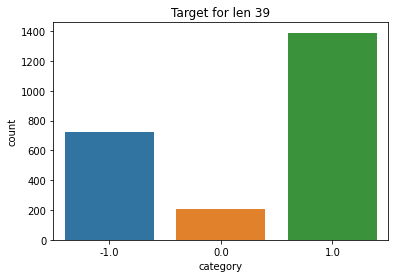

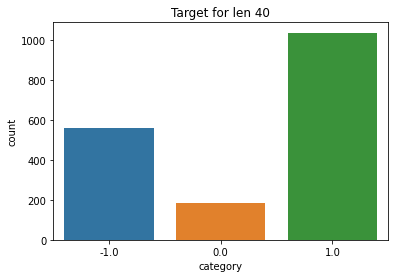

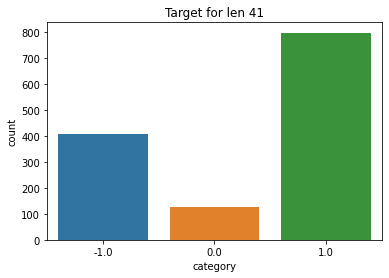

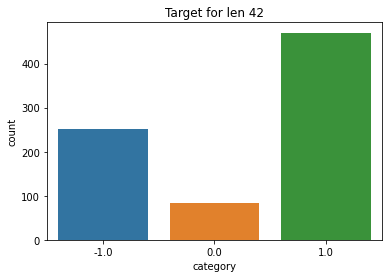

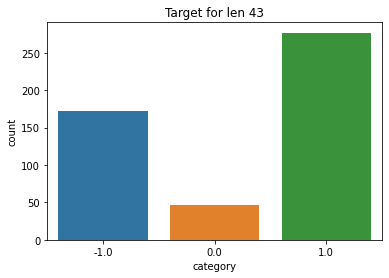

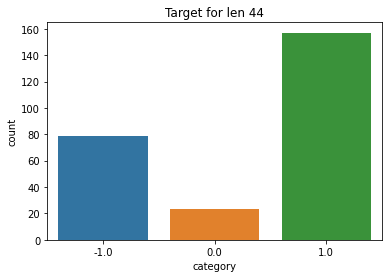

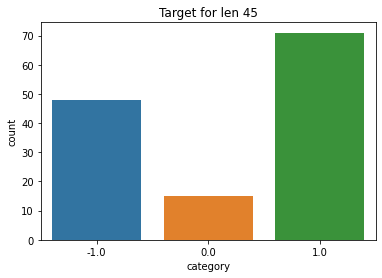

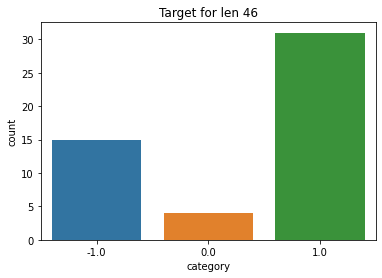

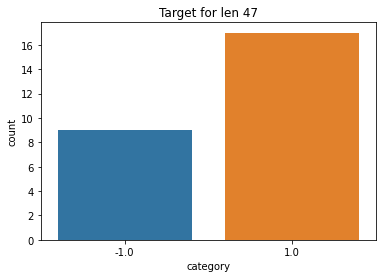

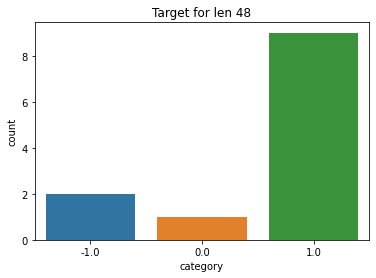

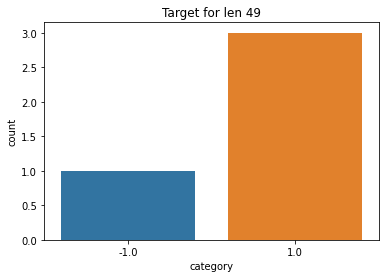

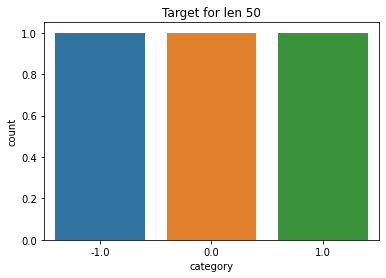

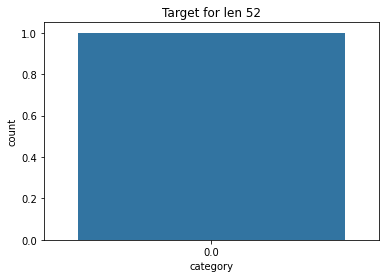

In [ ]:
# lets check for class distribution for different length of texts 
for i in sorted(df.len.unique()):
    sns.countplot(x='category',data=df.loc[df.len==i])
    plt.title('Target for len {}'.format(i))
    plt.show()

In [ ]:
# Post EDA and data pre processing, next step will be to vectorise text data

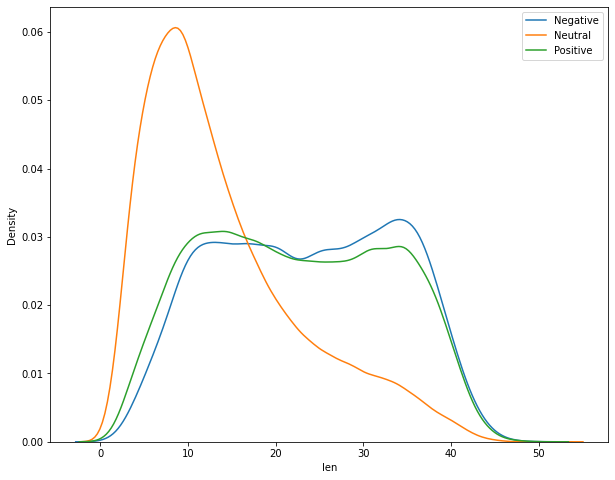

In [ ]:
plt.figure(figsize=(10,8))
sns.kdeplot(df.loc[df.category==-1].len)
sns.kdeplot(df.loc[df.category==0].len)
sns.kdeplot(df.loc[df.category==1].len)
plt.legend(['Negative','Neutral','Positive'])
plt.savefig('pdf.png')
plt.show()

In [ ]:
from wordcloud import WordCloud, STOPWORDS
def get_cloud(data):
    comment_words = ''
    for val in data:
        val = str(val)
        tokens = val.split()
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        tok=[]
        for i in tokens:
            if i not in STOPWORDS:
                tok.append(i)

        comment_words += " ".join(tok)+" "
    
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(comment_words)
    return wordcloud
def plot_cloud(x,t):
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(x)
    plt.title('X')
    plt.axis("off")
    plt.title(t)
    #plt.tight_layout(pad = 0)
    
    plt.show()

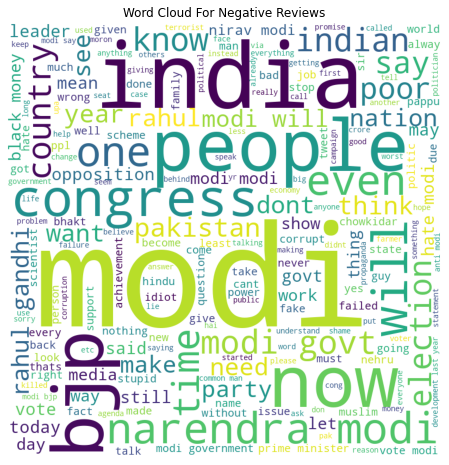

In [ ]:
wc=get_cloud(df.loc[df.category==-1].clean_text.values)
plot_cloud(wc,'Word Cloud For Negative Reviews')

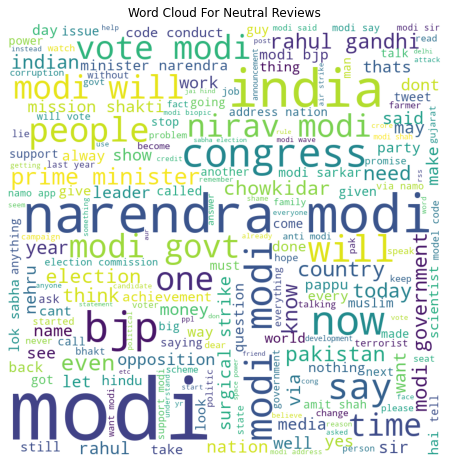

In [ ]:
wc=get_cloud(df.loc[df.category==0].clean_text.values)
plot_cloud(wc,'Word Cloud For Neutral Reviews')

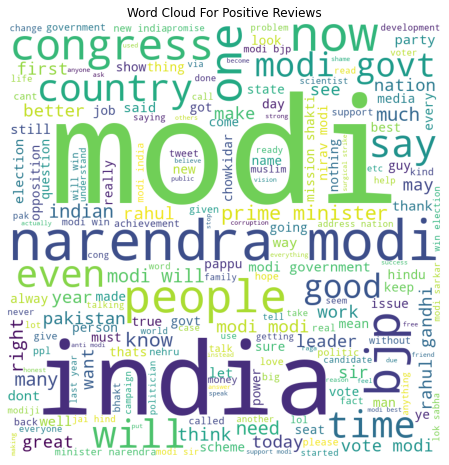

In [ ]:
wc=get_cloud(df.loc[df.category==1].clean_text.values)
plot_cloud(wc,'Word Cloud For Positive Reviews')